In [597]:
import sympy
import numpy as np
import matplotlib.pyplot as plt


def load_peak_table(savedir, zis, reflections):
    """
    Load the peak table from a series of npz files.

    The output data table holds data from multiple simulations
    with both ground truth and reconstructed data.

    The filepath names are assumed to follow the patterns:
    reflection_1_zi_m1.npz, reflection_1_zi_1.npz ... etc
    (where m1 stands for zi=-1)

    Args:
        savedir (str): Directory where the data is saved
        zis (list): List of z values (e.g. [-1, 0, 1])
        reflections (list): List of reflections (e.g. [1, 2, 3, 4])

    Returns:
        data (np.array): Array of npz files of shape (4, 3).
            each data instance is a dictionary with keys.
    """
    data = np.empty((4, 3), dtype=object)
    for reflection in reflections:
        for zi in zis:
            if zi < 0:
                ss = "_zi_m" + str(np.abs(zi))
            else:
                ss = "_zi_" + str(zi)
            fname = "reflection_" + str(reflection) + ss
            file = os.path.join(savedir, fname + ".npz")
            data[reflection - 1, zi + 1] = np.load(file)
    return data


import os

savedir = "/home/naxhe/workspace/darkmod/tests/end_to_end/defrec/saves/paper_1_run_3"
zis = [-1, 0, 1]
reflections = [1, 2, 3, 4]

data = load_peak_table(savedir, zis, reflections)


In [375]:
sigma, A, s = sympy.symbols("sigma A s", real=True, positive=True)

# this is the second derivative of the function with respect to s
# i.e it is the curvature of the function or hessian of the function
h = sympy.symbols("h", real=True)

p = sympy.symbols(
    "p", real=True, positive=True
)  # dot product between zl and xi i.e obliquity

In [376]:
# for a third order expansion the error due to diffraction line integral variation becomes
# the next error term is the 4rth order term.
w = A * sympy.exp(-((p * s) ** 2) / (2 * sigma**2))
gamma = h * s**2  # the second order term is even and contributes in the integral
t1 = sympy.integrate(gamma * w, (s, -sympy.oo, sympy.oo))
t2 = sympy.integrate(w, (s, -sympy.oo, sympy.oo))
integral_error = t1 / t2
total_error = integral_error - gamma.subs(s, 0)
total_error


h*sigma**2/p**2

In [377]:
sympy.integrate((h * s**4) * w, (s, -sympy.oo, sympy.oo))

3*sqrt(2)*sqrt(pi)*A*h*sigma**5/p**5

In [ ]:
from scipy.spatial.transform import Rotation


In [644]:
rmse = np.array(
    [
        0.933,
        0.983,
        0.679,
        0.518,
        0.915,
        0.455,
        0.378,
        0.381,
        0.236,
    ]
)

_sigma_z = 0.1
(2 * 0.1 * 1e-5) / ((_sigma_z) / np.dot(zl, xi)) ** 2

4.625711657330588e-05

In [625]:
1e-6 / ((0.2) / np.dot(zl, xi)) ** 2

5.782139571663233e-06

In [626]:
(0.43 * 2 * 1e-6 / ((0.1) / np.dot(zl, xi)) ** 2)

1.9890560126521524e-05

2.3128878096107144e-05

4.0

In [834]:
hkls = np.array([[-1, -1, 3], [-1.0, 1.0, 3.0], [1.0, 1.0, 3.0], [1.0, -1.0, 3.0]])

U0 = np.array(
    [
        [1.00000000e00, -6.02156939e-18, 1.06741601e-16],
        [-9.57823032e-18, 1.00000000e00, 3.98146086e-16],
        [-1.56587512e-16, -3.51707906e-16, 1.00000000e00],
    ]
)

B0 = np.array(
    [
        [1.55167197e00, -9.50125056e-17, -9.50125056e-17],
        [0.00000000e00, 1.55167197e00, -9.50125056e-17],
        [0.00000000e00, 0.00000000e00, 1.55167197e00],
    ]
)
Hmatrix = hkls.T
UB_reference = U0 @ B0
G_0 = UB_reference @ Hmatrix
y0 = G_0

scale = 2 * 1e-5
bias = np.random.normal(loc=0, scale=scale, size=G_0.shape)
y = G_0 + bias

F_true = np.eye(3, 3)
F_sample = np.linalg.inv(np.linalg.inv(y0 @ y0.T) @ y0 @ y.T)

error = F_sample - F_true

error

array([[ 5.75601683e-07, -1.11515704e-05,  4.46793661e-06],
       [-7.73396860e-06, -3.73013932e-06,  4.92442982e-06],
       [-5.49537402e-06,  7.17408498e-07, -6.25951933e-06]])

In [851]:
F_sample_inv = np.linalg.inv(y0 @ y0.T) @ y0 @ y.T

3

In [870]:
np.linalg.norm(np.linalg.inv(B0).T, axis=0) * 2 * np.pi

array([4.0493, 4.0493, 4.0493])

In [848]:
A = np.zeros((y0.size, F_true.size))
for i, v in enumerate(y0.T):
    A[i*3:(i+1)*3, 0:3] = np.diag(v)
    A[i*3:(i+1)*3, 3:6] = np.diag(v)
    A[i*3:(i+1)*3, 6:] = np.diag(v)

bias_y = bias.flatten(order='F')
#np.linalg.inv( A.T @ A ) @ A.T @ bias_y

np.linalg.matrix_rank(A.T @ A)

3

In [241]:
def F(x, scale):
    return np.eye(3, 3) + scale * np.ones((3, 3)) * x * x

In [286]:
F = data[0, 1]["defgrad"]
dx = data[0, 1]["voxel_size"]

In [291]:
Fi = np.linalg.inv(F.reshape(-1, 3, 3)).reshape(*F.shape)
FiT = np.transpose(Fi, axes=(0, 1, 2, 4, 3))
Q = FiT.reshape(-1, 3, 3) @ hkls[0]

In [ ]:
data[2, 1]["Q_sample_3D_true"].shape, data[2, 1]["hkl"]

((265, 265, 27, 3), array([1., 1., 3.]))

In [557]:
data[4, 1]["hkl"]

IndexError: index 4 is out of bounds for axis 0 with size 4

In [558]:
interp = [None] * 4
for reflection in range(0, 4):
    Q = data[reflection, 1]["Q_sample_3D_true"]
    x, y, z = (
        data[reflection, 1]["X"][:, 0, 0],
        data[reflection, 1]["Y"][0, :, 0],
        data[reflection, 1]["Z"][0, 0, :],
    )
    interp[reflection] = RegularGridInterpolator(
        (x, y, z), Q, method="cubic", bounds_error=False, fill_value=0
    )

In [585]:
dQ2ds2 = np.zeros((len(x), len(y), 4, 3))
for reflection in range(0, 4):
    dx = data[reflection, 1]["voxel_size"]
    s = np.arange(-2 * dx, 3 * dx, dx).reshape(-1, 1)
    ds = s[1, 0] - s[0, 0]
    center = len(s) // 2
    R_om = Rotation.from_rotvec(-np.array([0, 0, data[reflection, 1]["omega_0"]]))
    ray_path = R_om.apply(data[reflection, 1]["optical_axis"])
    points = ray_path * s
    for i in range(len(x)):
        for j in range(len(y)):
            translation = np.array([x[i], y[j], 0])
            Qs = interp[reflection](points + translation)
            dQ2ds2[i, j, reflection] = (
                (Qs[center + 1, :] - 2 * Qs[center, :] + Qs[center - 1, :]) / ds** 2
            )  # equivalent of  np.gradient( np.gradient(Qs, ds, axis=0), ds, axis=0)[len(s)//2]

In [586]:
for reflection in range(0, 4):
    R_om = Rotation.from_rotvec(-np.array([0, 0, data[reflection, 1]["omega_0"]]))
    ray_path = R_om.apply(data[reflection, 1]["optical_axis"])
    print(ray_path)

[ 0.83339912 -0.27232394  0.4809216 ]
[-0.27232394 -0.83339912  0.4809216 ]
[-0.83339912  0.27232394  0.4809216 ]
[0.27232394 0.83339912 0.4809216 ]


[ 1. -1.  3.]
40
(a) 0.05  x 1e-5
(b) 1.38  x 1e-5
(c) 22.0  x 1e-5
(d) 111.44  x 1e-5
40
(a) 0.05  x 1e-5
(b) 1.47  x 1e-5
(c) 21.69  x 1e-5
(d) 106.93  x 1e-5
40
(a) 0.03  x 1e-5
(b) 0.88  x 1e-5
(c) 12.56  x 1e-5
(d) 61.53  x 1e-5


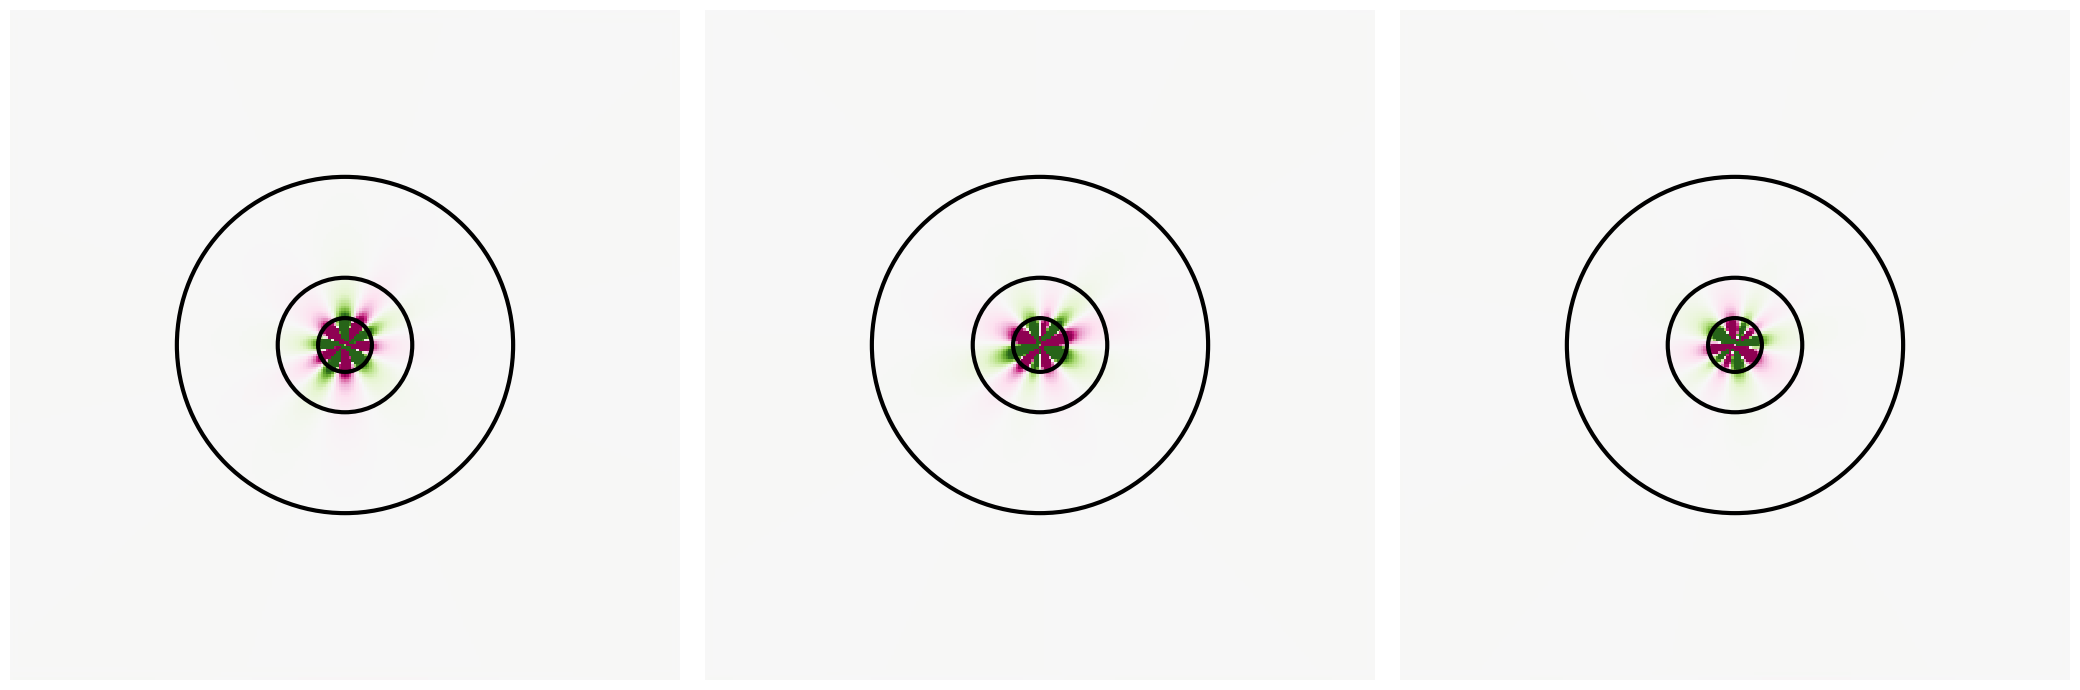

[1. 1. 3.]
40
(a) 0.06  x 1e-5
(b) 1.81  x 1e-5
(c) 25.51  x 1e-5
(d) 131.01  x 1e-5
Adding [1. 1. 3.]
40
(a) 0.05  x 1e-5
(b) 1.44  x 1e-5
(c) 21.17  x 1e-5
(d) 92.76  x 1e-5
Adding [1. 1. 3.]
40
(a) 0.03  x 1e-5
(b) 0.89  x 1e-5
(c) 12.36  x 1e-5
(d) 58.28  x 1e-5
Adding [1. 1. 3.]
(a) 0.04  x 1e-5
(b) 1.24  x 1e-5
(c) 17.69  x 1e-5
(d) 85.39  x 1e-5


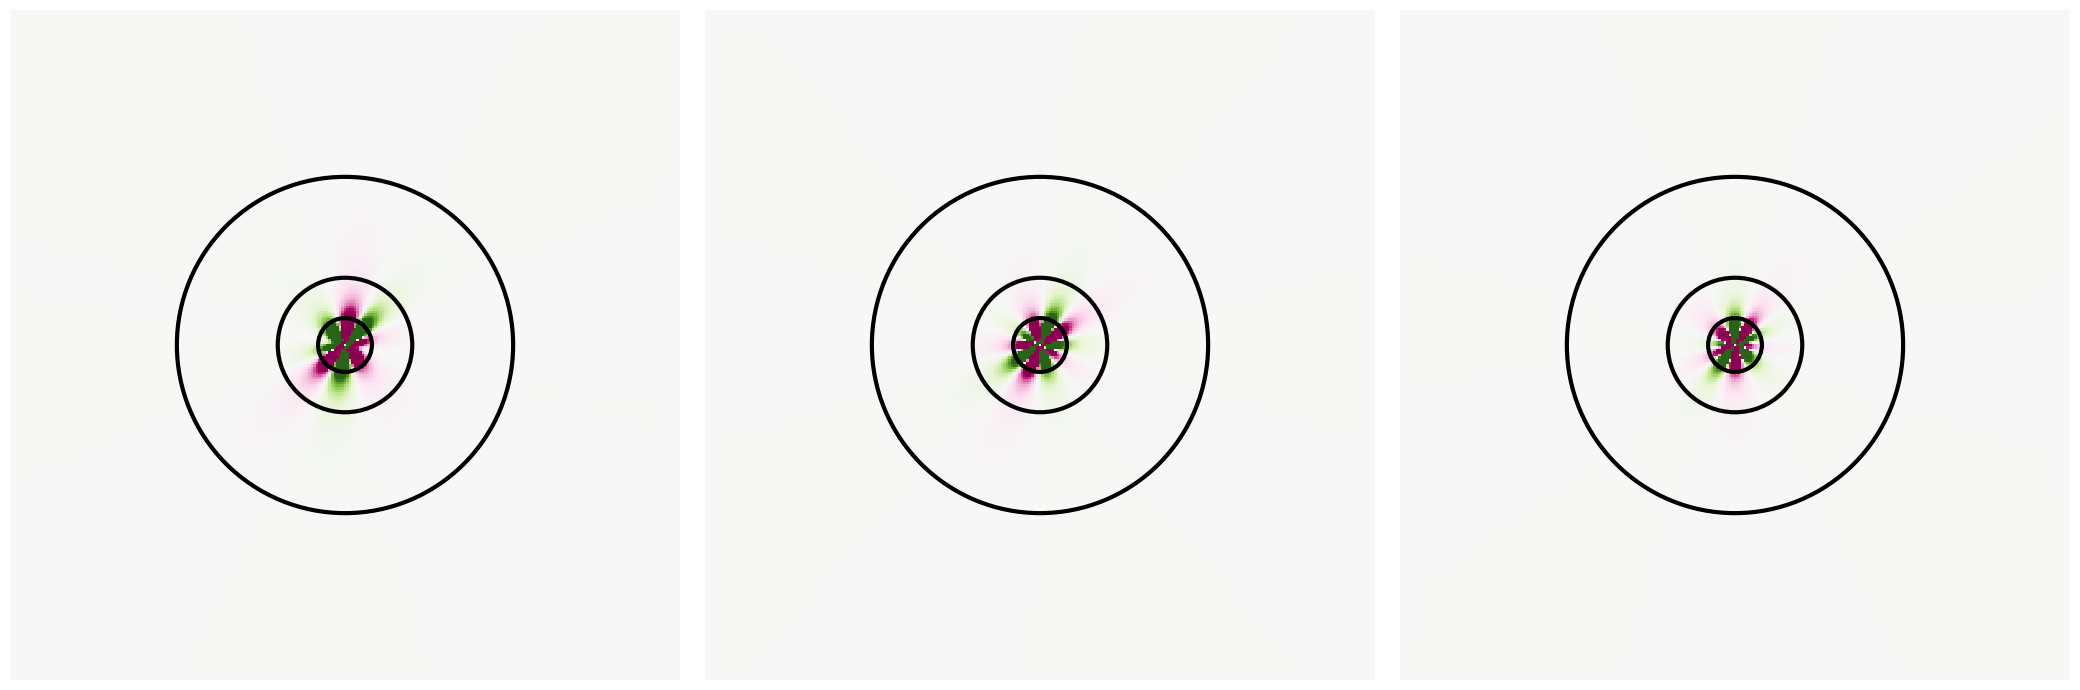

[-1.  1.  3.]
40
(a) 0.21  x 1e-5
(b) 5.97  x 1e-5
(c) 86.38  x 1e-5
(d) 439.96  x 1e-5
40
(a) 0.28  x 1e-5
(b) 8.16  x 1e-5
(c) 127.48  x 1e-5
(d) 658.31  x 1e-5
40
(a) 0.17  x 1e-5
(b) 4.9  x 1e-5
(c) 75.37  x 1e-5
(d) 371.99  x 1e-5


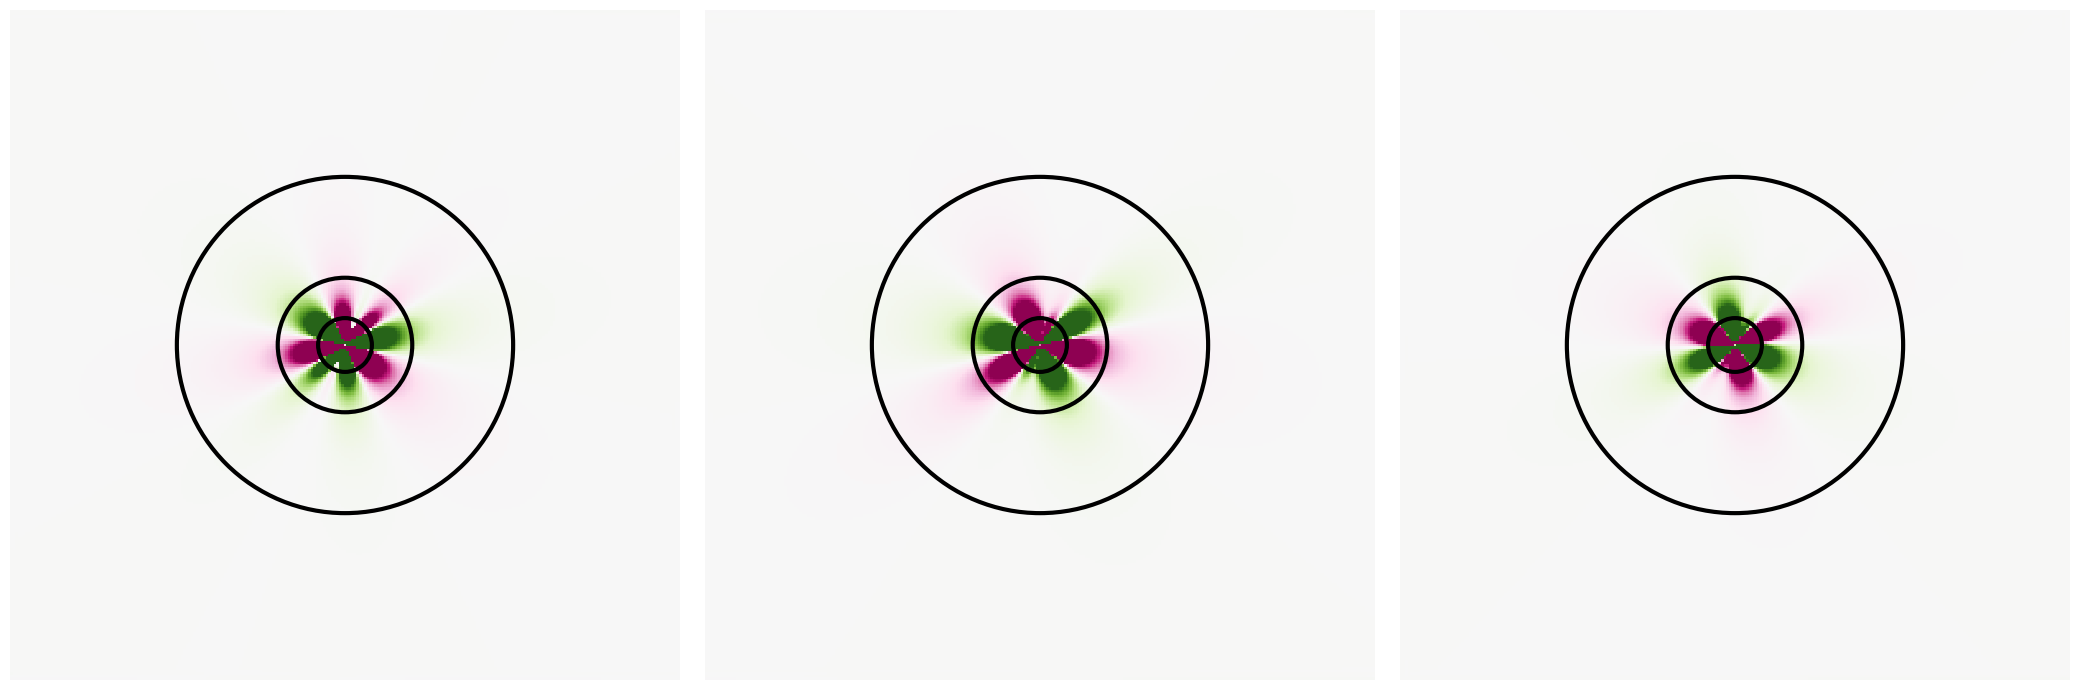

[-1 -1  3]
40
(a) 0.2  x 1e-5
(b) 5.93  x 1e-5
(c) 95.76  x 1e-5
(d) 503.58  x 1e-5
40
(a) 0.2  x 1e-5
(b) 5.8  x 1e-5
(c) 94.71  x 1e-5
(d) 482.28  x 1e-5
40
(a) 0.1  x 1e-5
(b) 2.91  x 1e-5
(c) 40.35  x 1e-5
(d) 204.27  x 1e-5


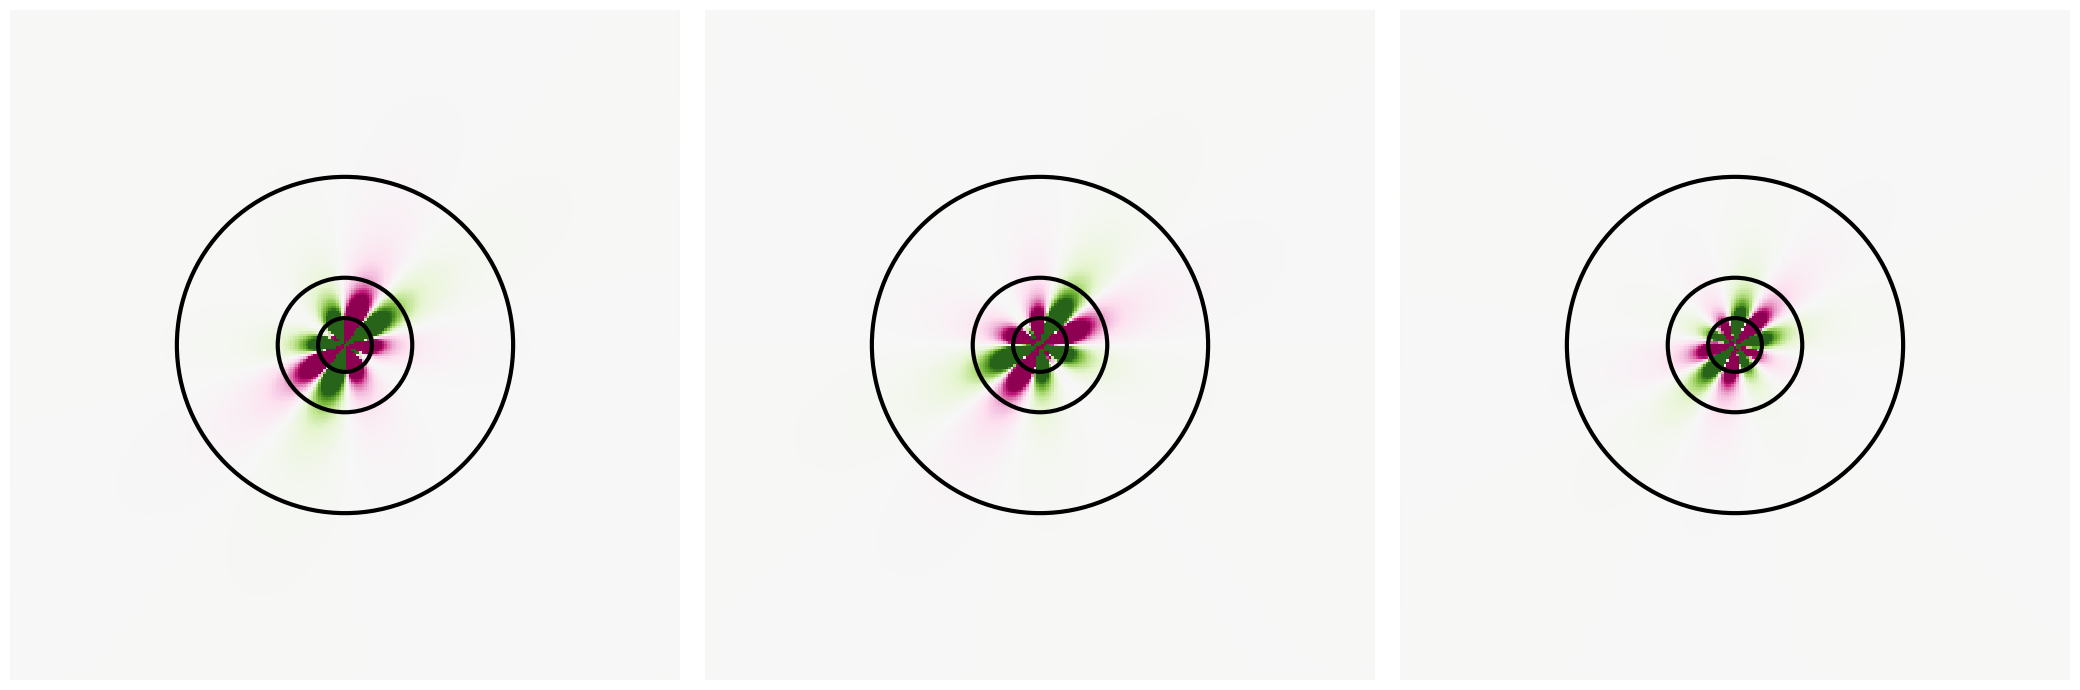

In [ ]:
plt.style.use("default")
curvature_errors = [[], [], [], []]
all_err_113 = [[], [], [], []]



for reflection in [3, 2, 1, 0]:
    fig, ax = plt.subplots(1, 3, figsize=(21, 7))
    Xgrid, Ygrid = data[reflection, 1]["X"][..., 13], data[reflection, 1]["Y"][..., 13]
    print(data[reflection, 1]["hkl"])
    for i in range(3):
        clip = 1

        theta = data[reflection, 1]["theta_0"]
        eta = data[reflection, 1]["eta_0"]
        omega = data[reflection, 1]["omega_0"]
        R_om = Rotation.from_rotvec(-np.array([0, 0, omega])).as_matrix()
        R_tth = Rotation.from_rotvec(np.array([0, -2 * theta, 0])).as_matrix()
        R_eta = Rotation.from_rotvec(np.array([eta, 0, 0])).as_matrix()
        xi = R_om @ R_eta @ R_tth @ np.array([1, 0, 0])
        zl = np.array([0, 0, 1])
        o_f = np.dot(zl, xi)
        sigma_z = 0.1

        error = dQ2ds2[clip:-clip, clip:-clip, reflection, i] * (sigma_z / o_f) ** 2
        curvature_errors[reflection].append(error)

        im = ax[i].pcolormesh(
            Xgrid[clip:-clip, clip:-clip],
            Ygrid[clip:-clip, clip:-clip],
            error,
            vmin=-10 * 1e-5,
            vmax=10 * 1e-5,
            cmap="PiYG",
        )
        # fig.colorbar(im, ax=ax[i], fraction=0.046, pad=0.04)
        ax[i].set_aspect("equal")
        for spine in ax[i].spines.values():
            spine.set_visible(False)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        circ1 = plt.Circle((0, 0), 0.4, color="black", fill=None, linewidth=3)
        ax[i].add_patch(circ1)
        circ2 = plt.Circle((0, 0), 1.0, color="black", fill=None, linewidth=3)
        ax[i].add_patch(circ2)
        circ3 = plt.Circle((0, 0), 2.5, color="black", fill=None, linewidth=3)
        ax[i].add_patch(circ3)

        Rxy = np.sqrt(
            Xgrid[clip:-clip, clip:-clip] ** 2 + Ygrid[clip:-clip, clip:-clip] ** 2
        )
        mask_c = (Rxy < 1.0 / 2.0) & (Rxy > 0.4 / 2.0)
        mask_a = np.ones_like(mask_c, dtype=bool)
        mask_a[Rxy < 2.5 / 2.0] = False 
        mask_b = (Rxy < 2.5 / 2.0) & (Rxy > 1.0 / 2.0)
        mask_d = (Rxy < 0.4 / 2.0) & (Rxy > 4 * data[reflection, 1]["voxel_size"])
        print(np.sum(mask_d))

        # print('(a)', np.sqrt(np.sum(error[mask_a]**2) / np.sum(mask_a)) / 1e-6, ' x 1e-6')
        # print('(b)', np.sqrt(np.sum(error[mask_b]**2) / np.sum(mask_b)) / 1e-5, ' x 1e-5')
        # print('(c)', np.sqrt(np.sum(error[mask_c]**2) / np.sum(mask_c)) / 1e-4, ' x 1e-4')
        # print('(d)', np.sqrt(np.sum(error[mask_d]**2) / np.sum(mask_d)) / 1e-3, ' x 1e-3')

        print(
            "(a)",
            np.round(np.sqrt(np.sum(error[mask_a] ** 2) / np.sum(mask_a)) / 1e-5, 2),
            " x 1e-5",
        )
        print(
            "(b)",
            np.round(np.sqrt(np.sum(error[mask_b] ** 2) / np.sum(mask_b)) / 1e-5, 2),
            " x 1e-5",
        )
        print(
            "(c)",
            np.round(np.sqrt(np.sum(error[mask_c] ** 2) / np.sum(mask_c)) / 1e-5, 2),
            " x 1e-5",
        )
        print(
            "(d)",
            np.round(np.sqrt(np.sum(error[mask_d] ** 2) / np.sum(mask_d)) / 1e-5, 2),
            " x 1e-5",
        )

        if reflection == 2:
            print("Adding", data[reflection, 1]["hkl"])
            all_err_113[0].append(list(error[mask_a]))
            all_err_113[1].append(list(error[mask_b]))
            all_err_113[2].append(list(error[mask_c]))
            all_err_113[3].append(list(error[mask_d]))
    if reflection == 2:

        for j in range(4):
            all_err_113[j] = np.linalg.norm(np.array(all_err_113[j]), axis=0)        
        

        print(
            "(a)",
            np.round(
                np.sqrt(np.sum(all_err_113[0] ** 2) / len(all_err_113[0])) / 2 / 1e-5, 2
            ),
            " x 1e-5",
        )
        print(
            "(b)",
            np.round(
                np.sqrt(np.sum(all_err_113[1] ** 2) / len(all_err_113[1])) / 2 / 1e-5, 2
            ),
            " x 1e-5",
        )
        print(
            "(c)",
            np.round(
                np.sqrt(np.sum(all_err_113[2] ** 2) / len(all_err_113[2])) / 2 / 1e-5, 2
            ),
            " x 1e-5",
        )
        print(
            "(d)",
            np.round(
                np.sqrt(np.sum(all_err_113[3] ** 2) / len(all_err_113[3])) / 2 / 1e-5, 2
            ),
            " x 1e-5",
        )

    plt.tight_layout()
    plt.show()


In [884]:
betas = np.load("betas.npy")[1]
betas_true = np.load("betas_true.npy")[1]
residual = betas_true - betas
curvature_error = np.array(curvature_errors) # 113
curvature_error_padded = np.zeros((4, 3, curvature_error.shape[2]+2, curvature_error.shape[3]+2))
curvature_error_padded[..., 1:-1, 1:-1] = curvature_error
curvature_error = curvature_error_padded

In [885]:
curvature_error.shape

(4, 3, 265, 265)

In [1026]:
data[2,1]['Z'].max()

0.4924242424242422

In [1033]:
F_true = betas_true.copy()
for i in range(3):
    F_true[..., i, i]+=1
A = np.linalg.inv(y0 @ y0.T) @ y0


dF = np.zeros_like(F_true)
for i in range(curvature_error.shape[2]):
   for j in range(curvature_error.shape[3]):
       bias = curvature_error[...,i,j].T
       if not np.allclose(bias, 0):
            # woodbury with U and V as identity
            dF[i, j] = - F_true[i, j] @ np.linalg.inv( np.linalg.inv( A @ bias.T ) + F_true[i, j]) @ F_true[i, j]

In [1085]:
mask_bd = ( Rxy[1:-1,1:-1] < 2.5 )

mask_a = np.ones_like(mask_c, dtype=bool)
mask_a[Rxy[1:-1,1:-1] < 2.5 / 2.0] = False 
mask_b = (Rxy[1:-1,1:-1] < 2.5) & (Rxy[1:-1,1:-1] > 1.0)
mask_c = (Rxy[1:-1,1:-1] < 1.0 ) & (Rxy[1:-1,1:-1] > 0.4 )
mask_d = (Rxy[1:-1,1:-1] < 0.4)


"""$\beta_{11}$ & 0.018   & 0.100    & 1.560    & 117.827 \\
$\beta_{12}$ & 0.021   & 0.114    & 1.785    & 161.980 \\
$\beta_{13}$ & 0.013   & 0.072    & 1.131    & 67.421  \\
$\beta_{21}$ & 0.023   & 0.123    & 1.919    & 109.580 \\
$\beta_{22}$ & 0.026   & 0.144    & 2.245    & 120.870 \\
$\beta_{23}$ & 0.016   & 0.086    & 1.316    & 53.373  \\
$\beta_{31}$ & 0.007   & 0.040    & 0.625    & 50.654  \\
$\beta_{32}$ & 0.007   & 0.039    & 0.620    & 58.042  \\
$\beta_{33}$ & 0.005   & 0.025    & 0.389    & 23.212  \\
"""

tab = """\\begin{table}[h]
\centering
\\begin{tabular}{c cccc}
\hline
            & zone (a) & zone (b) & zone (c) & zone (d) \\
\hline
"""

for i in range(3):
    for j in range(3):
        tab +=  "$\\beta_{"+str(i+1)+str(j+1)+"}$"
        for ss, mask in zip(['a', 'b', 'c', 'd'],[mask_a, mask_b, mask_c, mask_d]):
            tab +=  " & " + str(np.round( np.mean(np.abs(dF[1:-1,1:-1][mask, i,j]),  axis=0)/1e-5, 3))
        tab += ' \\\ \n'
tab += """\hline
\end{tabular}
\caption{MAE bias values per zone}
\label{tab:MAE_bias}
\end{table}"""
print(tab)


\begin{table}[h]
\centering
\begin{tabular}{c cccc}
\hline
            & zone (a) & zone (b) & zone (c) & zone (d) \
\hline
$\beta_{11}$ & 0.018 & 0.1 & 1.56 & 117.827 \\ 
$\beta_{12}$ & 0.021 & 0.114 & 1.785 & 161.98 \\ 
$\beta_{13}$ & 0.013 & 0.072 & 1.131 & 67.421 \\ 
$\beta_{21}$ & 0.023 & 0.123 & 1.919 & 109.58 \\ 
$\beta_{22}$ & 0.026 & 0.144 & 2.245 & 120.87 \\ 
$\beta_{23}$ & 0.016 & 0.086 & 1.316 & 53.373 \\ 
$\beta_{31}$ & 0.007 & 0.04 & 0.625 & 50.654 \\ 
$\beta_{32}$ & 0.007 & 0.039 & 0.62 & 58.042 \\ 
$\beta_{33}$ & 0.005 & 0.025 & 0.389 & 23.212 \\ 
\hline
\end{tabular}
\caption{MAE bias values per zone}
\label{tab:MAE_bias}
\end{table}


In [1131]:
for reflection in [3,2,1,0]:
    theta = data[reflection, 1]["theta_0"]
    eta = data[reflection, 1]["eta_0"]
    omega = data[reflection, 1]["omega_0"]
    R_om = Rotation.from_rotvec(-np.array([0, 0, omega])).as_matrix()
    R_tth = Rotation.from_rotvec(np.array([0, -2 * theta, 0])).as_matrix()
    R_eta = Rotation.from_rotvec(np.array([eta, 0, 0])).as_matrix()
    xi = R_om @ R_eta @ R_tth @ np.array([1, 0, 0])
    zl = np.array([0, 0, 1])
    o_f = np.dot(zl, xi)
    sigma_z = 0.1
    print(sigma_z / o_f / voxz)

5.4894602657773985
5.4894602657773985
5.4894602657773985
5.4894602657773985


In [1188]:
np.max( np.abs(dF[1:-1,1:-1][mask_a]), axis=0 ), dF[1:-1,1:-1][mask_a].shape

(array([[4.40700682e-06, 4.60241579e-06, 3.13637398e-06],
        [5.19604105e-06, 8.52625982e-06, 4.14233422e-06],
        [1.73128424e-06, 1.85172633e-06, 1.14579540e-06]]),
 (65764, 3, 3))

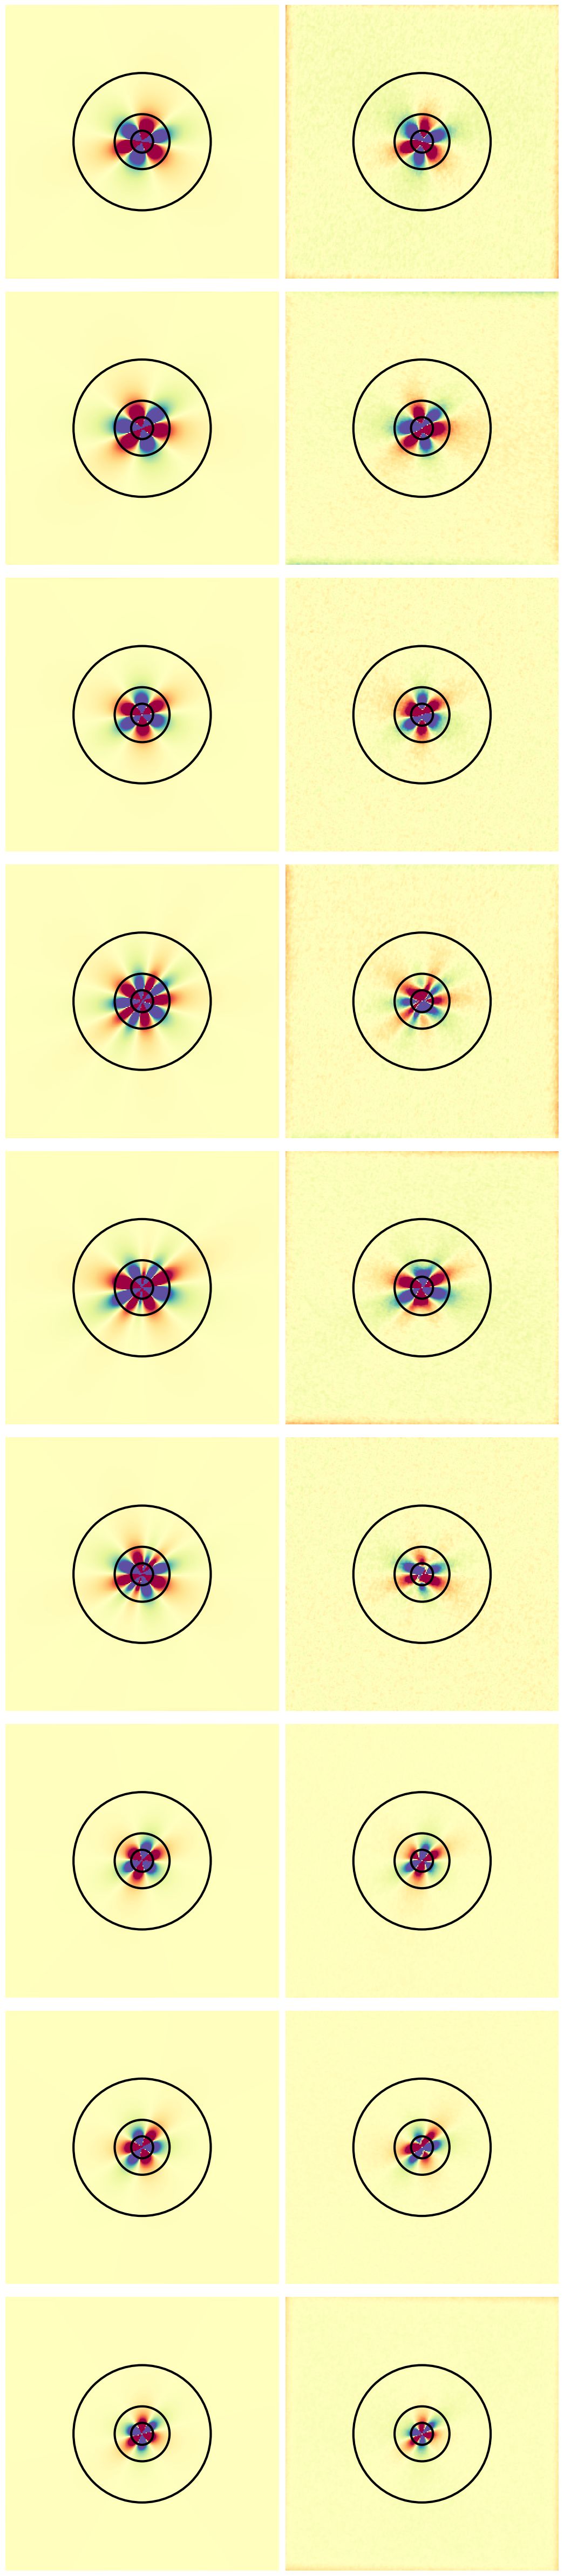

In [1211]:
plt.style.use('default')
%matplotlib inline
fontsize = 16
ticksize= 16
plt.rcParams['font.size'] = fontsize
plt.rcParams['xtick.labelsize'] = ticksize
plt.rcParams['ytick.labelsize'] = ticksize
plt.rcParams['font.family'] = 'Times New Roman'


mask_bd = ( Rxy[1:-1,1:-1] < 2.5 )
mask_bd[:,:] = True
def crop(arr, mask):
    rows = mask.any(axis=1)
    cols = mask.any(axis=0)
    rmin, rmax = rows.nonzero()[0][[0, -1]]
    cmin, cmax = cols.nonzero()[0][[0, -1]]
    return arr[rmin:rmax+1, cmin:cmax+1]

fig, ax = plt.subplots(9, 2, figsize=(11, 12*4))
k=0
for i in range(3):
   for j in range(3):
        _s1 = -dF[1:-1,1:-1, i, j].copy()


        _s1[~mask_bd] = np.nan

        X, Y = crop(Xgrid[1:-1,1:-1], mask_bd), crop(Ygrid[1:-1,1:-1], mask_bd)
        im = ax[k, 0].pcolormesh(X, Y, crop(_s1, mask_bd), vmin=-1e-5, vmax=1e-5, cmap='Spectral_r', shading='nearest')
        #fig.colorbar(im, ax=ax[k, 0], fraction=0.046, pad=0.04)
        _s2 = residual[1:-1,1:-1, i, j].copy()
        _s2[~mask_bd] = np.nan
        im = ax[k, 1].pcolormesh(X, Y, crop(_s2, mask_bd), vmin=-1e-5, vmax=1e-5, cmap='Spectral_r', shading='nearest')
        #fig.colorbar(im, ax=ax[k, 1], fraction=0.046, pad=0.04)
        circ1 = plt.Circle((0, 0), 0.4, color="black", fill=None, linewidth=3)
        ax[k, 0].add_patch(circ1)
        circ2 = plt.Circle((0, 0), 0.4, color="black", fill=None, linewidth=3)
        ax[k, 1].add_patch(circ2)
        circ1 = plt.Circle((0, 0), 1.0, color="black", fill=None, linewidth=3)
        ax[k, 0].add_patch(circ1)
        circ2 = plt.Circle((0, 0), 1.0, color="black", fill=None, linewidth=3)
        ax[k, 1].add_patch(circ2)
        circ1 = plt.Circle((0, 0), 2.5, color="black", fill=None, linewidth=3)
        ax[k, 0].add_patch(circ1)
        circ2 = plt.Circle((0, 0), 2.5, color="black", fill=None, linewidth=3)
        ax[k, 1].add_patch(circ2)
        k+=1

        #print(k, np.corrcoef(_s1[mask_bd], _s2[mask_bd])[0, 1])
        #_s1 = -dF[1:-1,1:-1, i, j].copy()
        #_s2 = residual[1:-1,1:-1, i, j].copy()
        #print(k, np.corrcoef(_s1[mask_a], _s2[mask_a])[0, 1])
        #print(k, np.corrcoef(_s1[mask_b], _s2[mask_b])[0, 1])
        #print(k, np.corrcoef(_s1[mask_c], _s2[mask_c])[0, 1])
        #print(k, np.corrcoef(_s1[mask_d], _s2[mask_d])[0, 1])

for a in ax.flatten():
    a.set_aspect("equal")
    a.set_xticks([])
    a.set_yticks([])
    for spine in a.spines.values():
        spine.set_visible(False)
plt.tight_layout()
plt.show()

[2.60000000e+00 2.55874603e+00 2.51749206e+00 2.47623810e+00
 2.43498413e+00 2.39373016e+00 2.35247619e+00 2.31122222e+00
 2.26996825e+00 2.22871429e+00 2.18746032e+00 2.14620635e+00
 2.10495238e+00 2.06369841e+00 2.02244444e+00 1.98119048e+00
 1.93993651e+00 1.89868254e+00 1.85742857e+00 1.81617460e+00
 1.77492063e+00 1.73366667e+00 1.69241270e+00 1.65115873e+00
 1.60990476e+00 1.56865079e+00 1.52739683e+00 1.48614286e+00
 1.44488889e+00 1.40363492e+00 1.36238095e+00 1.32112698e+00
 1.27987302e+00 1.23861905e+00 1.19736508e+00 1.15611111e+00
 1.11485714e+00 1.07360317e+00 1.03234921e+00 9.91095238e-01
 9.49841270e-01 9.08587302e-01 8.67333333e-01 8.26079365e-01
 7.84825397e-01 7.43571429e-01 7.02317460e-01 6.61063492e-01
 6.19809524e-01 5.78555556e-01 5.37301587e-01 4.96047619e-01
 4.54793651e-01 4.13539683e-01 3.72285714e-01 3.31031746e-01
 2.89777778e-01 2.48523810e-01 2.07269841e-01 1.66015873e-01
 1.24761905e-01 8.35079365e-02 4.22539683e-02 1.00000000e-03]


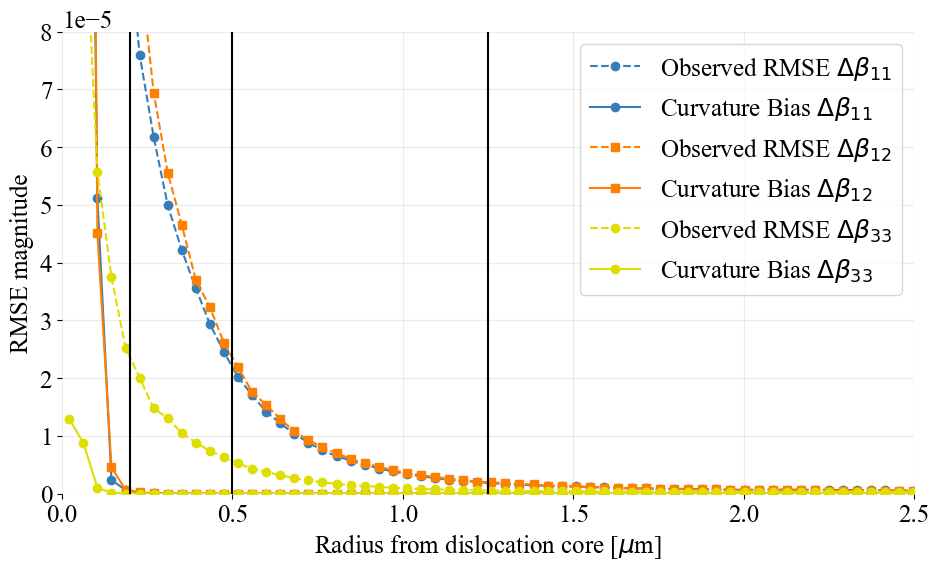

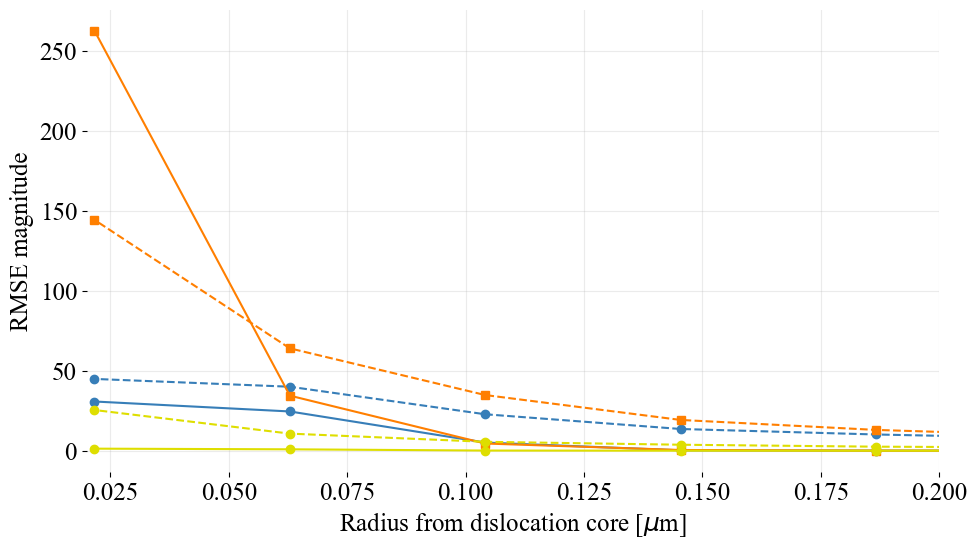

In [953]:
Rxy = np.sqrt(Xgrid**2 + Ygrid**2)
radii = np.linspace( 2.6, 0.001, 64 )
print(radii)
rmse = []
curvature_rmse = []
for i in range(len(radii)-1):
    mask = (Rxy < radii[i]) * (Rxy > radii[i+1])
    rmse.append( np.sqrt( np.sum(residual[mask].reshape(np.sum(mask), 9)**2, axis=0) / np.sum(mask) ) )
    curvature_rmse.append( np.sum(dF[mask].reshape(np.sum(mask), 9)**2, axis=0) / np.sum(mask) ) 
rmse = np.array(rmse)
curvature_rmse = np.array(curvature_rmse)


fontsize = 18
ticksize= 18
plt.style.use('default')
plt.rcParams['font.size'] = fontsize
plt.rcParams['xtick.labelsize'] = ticksize
plt.rcParams['ytick.labelsize'] = ticksize
plt.rcParams['font.family'] = 'Times New Roman'
fig, ax = plt.subplots(1, 1, figsize=(11,6))
rr = (radii[0:-1] + radii[1:])/2.
linestyles = ["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":"]
markers = ["o", "s", "D", "x", "o", "s", "D", "x", "o", "s", "D", "x"]
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00', 'k', 'k', 'k']
labels = [ 'Observed RMSE $\Delta \\beta_{11}$', 'Observed RMSE $\Delta \\beta_{12}$', 'Observed RMSE $\Delta \\beta_{13}$', 'Observed RMSE $\Delta \\beta_{21}$', 'Observed RMSE $\Delta \\beta_{22}$', 'Observed RMSE $\Delta \\beta_{23}$', 'Observed RMSE $\Delta \\beta_{31}$', 'Observed RMSE $\Delta \\beta_{32}$', 'Observed RMSE $\Delta \\beta_{33}$', 
           'Curvature Bias $\Delta \\beta_{11}$', 'Curvature Bias $\Delta \\beta_{12}$', 'Curvature Bias $\Delta \\beta_{13}$', 'Curvature Bias $\Delta \\beta_{21}$', 'Curvature Bias $\Delta \\beta_{22}$', 'Curvature Bias $\Delta \\beta_{23}$', 'Curvature Bias $\Delta \\beta_{31}$', 'Curvature Bias $\Delta \\beta_{32}$', 'Curvature Bias $\Delta \\beta_{33}$',  ]
for i, _rmse in enumerate(rmse.T):
    if i==0 or i==8 or i==1:
        ax.plot(rr, _rmse, linestyle=linestyles[1], color=CB_color_cycle[i], marker=markers[i], label=labels[i])
        ax.plot(rr, curvature_rmse[:, i], color=CB_color_cycle[i], marker=markers[i], label=labels[i+9], linestyle=linestyles[0])

# 0.2, 0.5, 1.25
ax.grid(True, alpha=0.25)
ax.legend(ncols=1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xlabel('')
ax.set_xlim([0, 2.5])
ax.set_ylim([0, 0.00008])
ax.vlines(0.2, 0, 0.00008, 'k')
ax.vlines(0.5, 0, 0.00008, 'k')
ax.vlines(1.25, 0, 0.00008, 'k')
ax.set_xlabel('Radius from dislocation core [$\mu$m]')
ax.set_ylabel('RMSE magnitude')
plt.show()

# 0.2, 0.5, 1.25
fig, ax = plt.subplots(1, 1, figsize=(11,6))
for i, _rmse in enumerate(rmse.T):
    if i==0 or i==8 or i==1:
        ax.plot(rr, _rmse / 1e-5, linestyle=linestyles[1], color=CB_color_cycle[i], marker=markers[i], label=labels[i])
        ax.plot(rr, curvature_rmse[:, i] / 1e-5, color=CB_color_cycle[i], marker=markers[i], label=labels[i+9], linestyle=linestyles[0])
ax.grid(True, alpha=0.25)

for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xlabel('')
ax.set_xlim([0.02, 0.2])
#ax.set_ylim([0, 0.000015])
#ax.vlines(0.2, 0, 0.000015, 'k')
#ax.vlines(0.5, 0, 0.000015, 'k')
#ax.vlines(1.25, 0, 0.000015, 'k')
ax.set_xlabel('Radius from dislocation core [$\mu$m]')
ax.set_ylabel('RMSE magnitude')
plt.show()

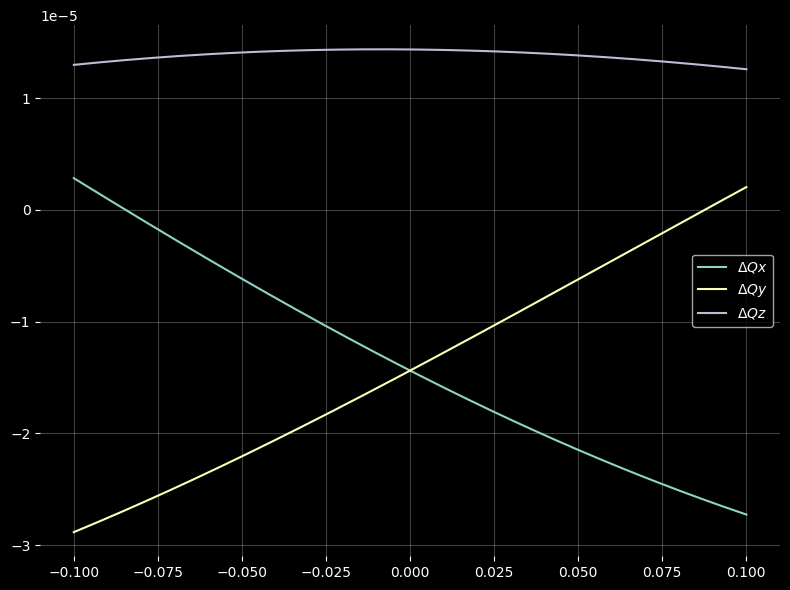

In [485]:
s = np.linspace(-0.1, 0.1, 256).reshape(-1, 1)
points = data[2, 1]["optical_axis"] * s
translation = np.array([0.5, 0.5, 0])
Qs = interp(points + translation)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(s, Qs[..., 0], label="$\Delta Qx$")
ax.plot(s, Qs[..., 1], label="$\Delta Qy$")
ax.plot(s, Qs[..., 2], label="$\Delta Qz$")
ax.grid(True, alpha=0.25)
ax.legend()
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

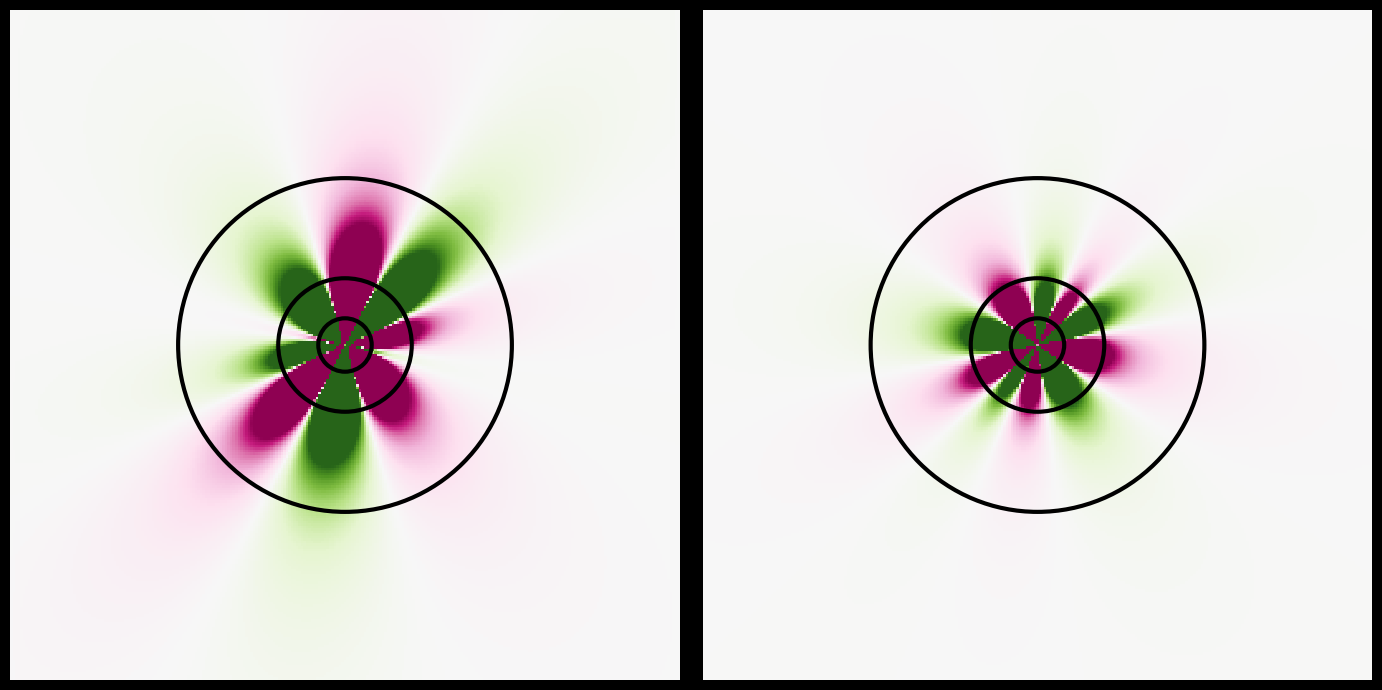

In [396]:
voxz = data[2, 1]["voxel_size"]

dQx, dQy, dQz = np.gradient(
    Q[..., 0],
    voxz,
    voxz,
    voxz,
)
dQ2dx2, _, _ = np.gradient(
    dQx,
    voxz,
    voxz,
    voxz,
)
dQx, dQy, dQz = np.gradient(Q[..., 1], voxz, voxz, voxz)
_, _, dQ2dz2 = np.gradient(
    dQz,
    voxz,
    voxz,
    voxz,
)
X, Y = data[2, 1]["X"][..., 13], data[2, 1]["Y"][..., 13]

plt.style.use("dark_background")
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
im = ax[0].pcolormesh(
    X, Y, dQ2dx2[..., 13], vmin=-4.6 * 1e-5, vmax=4.6 * 1e-5, cmap="PiYG"
)
im = ax[1].pcolormesh(
    X, Y, dQ2dz2[..., 13], vmin=-4.6 * 1e-5, vmax=4.6 * 1e-5, cmap="PiYG"
)
ax[0].set_aspect("equal")
ax[1].set_aspect("equal")
# fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)

for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

    circ1 = plt.Circle((0, 0), 0.4, color="black", fill=None, linewidth=3)
    ax[i].add_patch(circ1)
    circ2 = plt.Circle((0, 0), 1.0, color="black", fill=None, linewidth=3)
    ax[i].add_patch(circ2)
    circ3 = plt.Circle((0, 0), 2.5, color="black", fill=None, linewidth=3)
    ax[i].add_patch(circ3)

for i, a in enumerate(ax.flatten()):
    for spine in a.spines.values():
        spine.set_visible(False)

plt.tight_layout()
plt.show()